### Optimal control of the FHN model
This notebook shows how to compute the optimal control signal for the FHN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
fhn = FHNModel()

# Some parameters to define stimulation signals
dt = fhn.params["dt"]
duration = 10.
amplitude = 1.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(np.arange(0,duration-0.2, dt)) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])

In [3]:
# define plot function for later convenience
def plot_singlenode(state, target, control, input, weight_array=[]):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

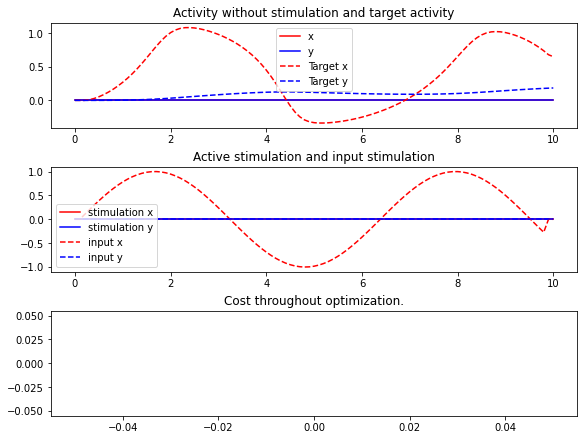

In [4]:
# We set the stimulus in x and y variables, and run the simulation
fhn.params["x_ext"] = input
fhn.params["y_ext"] = zero_input
fhn.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
fhn.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_singlenode(state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 1: 21.23999415799802


/home/lena/Promotion/neurolib/neurolib/optimal_control/oc_fhn/oc_fhn_jit.py:108: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  + adjoint_state[n, :, ind + 1] @ hx[n, ind + 1]
/home/lena/Promotion/neurolib/neurolib/optimal_control/oc_fhn/oc_fhn_jit.py:111: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  der += adjoint_state[n2, :, ind + 1] @ hx_nw[n2, n, ind + 1]
/home/lena/.local/lib/python3.9/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/lena/.local/lib/python3.9/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))
E

Cost in iteration 2: 16.54619603484711
diverging model output, decrease step size to  1.0
Cost in iteration 100: 0.7313237652557407
Cost in iteration 200: 0.19947969393276857
Cost in iteration 300: 0.06797848994801177
Cost in iteration 400: 0.03067514748024182
Cost in iteration 500: 0.015244589613907992


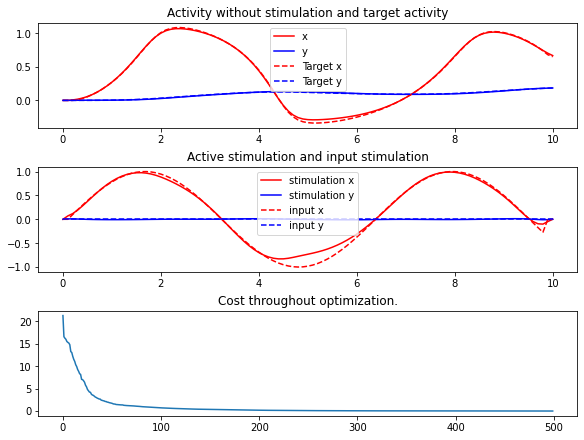

In [5]:
# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=[1,2,100,200,300,400,500])

# We run 500 iterations of the optimal control gradient descent algorithm
fhn_controlled.optimize(500)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_singlenode(state, target, control, target_input, fhn_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 1: 0.015217612515047808
Cost in iteration 2: 0.014994947626458876
Cost in iteration 100: 0.008306285101670337


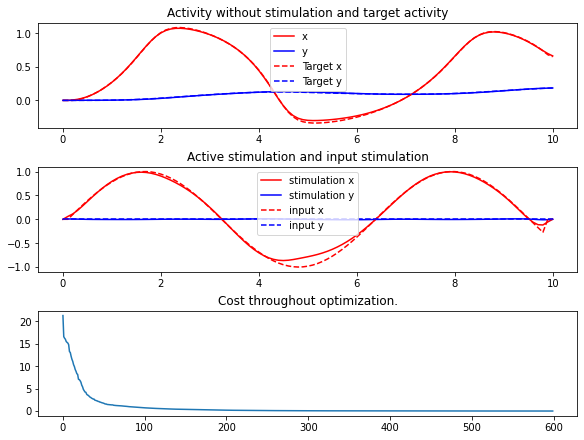

In [6]:
# Do another 100 iterations if you want to
# repeated execution will continue with further 100 iterations
fhn_controlled.optimize(100)
state = fhn_controlled.get_xs()
control = fhn_controlled.control
plot_singlenode(state, target, control, target_input, fhn_controlled.cost_history)

### Network case

In [16]:
# define plot function for later convenience
def plot_nw(state, target, control, input, weight_array=[], step_array=[]):

    t_array = np.arange(0, duration+dt, dt)
    fig, ax = plt.subplots( 3,2, figsize=(12,8), constrained_layout=True)

    for n in range(fhn.params.N):
        ax[0,n].plot(t_array, state[n,0,:], label="x", color=color_x)
        ax[0,n].plot(t_array, state[n,1,:], label="y", color=color_y)
        ax[0,n].plot(t_array, target[n,0,:], linestyle='dashed', label="Target x", color=color_x)
        ax[0,n].plot(t_array, target[n,1,:], linestyle='dashed', label="Target y", color=color_y)
        ax[0,n].legend()
        ax[0,n].set_title(f"Activity and target, node %s" % (n))

        # Plot the target control signal (dashed line) and "initial" zero control signal
        ax[1,n].plot(t_array, control[n,0,:], label="stimulation x", color=color_x)
        ax[1,n].plot(t_array, control[n,1,:], label="stimulation y", color=color_y)
        ax[1,n].plot(t_array, input[n,0,:], linestyle='dashed', label="input x", color=color_x)
        ax[1,n].plot(t_array, input[n,1,:], linestyle='dashed', label="input y", color=color_y)
        ax[1,n].legend()
        ax[1,n].set_title(f"Stimulation and input, node %s" % (n))

    ax[2,0].plot(weight_array)
    ax[2,0].set_title("Cost throughout optimization.")

    ax[2,1].plot(step_array)
    ax[2,1].set_title("Step size throughout optimization.")

    ax[2,1].set_ylim(bottom=0,top=None)

    plt.show()

Let us know study a simple 2-node network of FHN oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

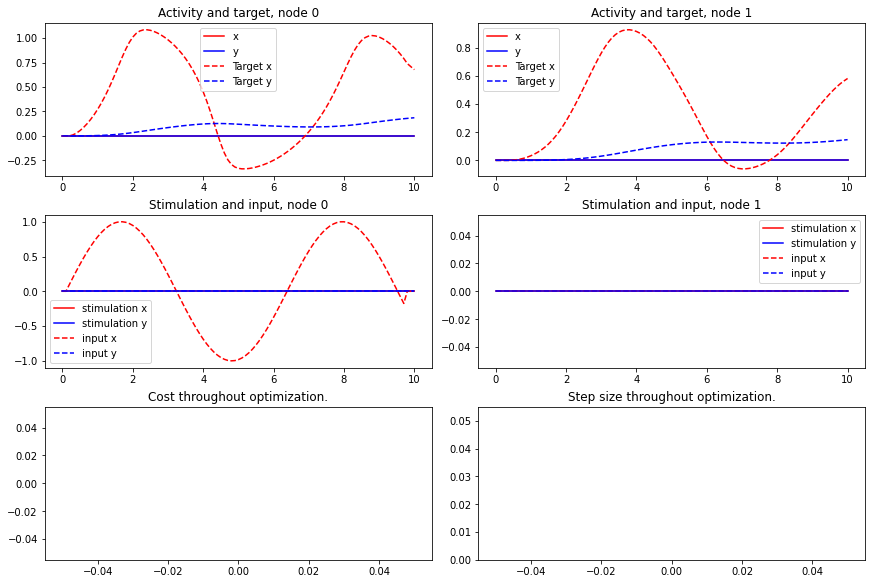

In [26]:
cmat = np.array( [[0., 0.], [1., 0.]] )  # diagonal elements are zero, connection stregth is 1 (0.) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (fhn.params.N, len(fhn.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

fhn = FHNModel(Cmat=cmat, Dmat=dmat)
fhn.params.coupling = "additive" # use additive coupling
if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    fhn.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

fhn.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
fhn.params["xs_init"] = np.vstack( [x_init, x_init] )
fhn.params["ys_init"] = np.vstack( [y_init, y_init] )



# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

fhn.params["x_ext"] = input_nw[:,0,:]
fhn.params["y_ext"] = input_nw[:,1,:]

fhn.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_nw(state, target, zero_input_nw, input_nw)

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Compute control for a deterministic system
Cost in iteration 1: 64.939833991778
diverging model output, decrease step size to  5.0
Cost in iteration 2: 39.632515147235324
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
diverging model output, decrease step size to  0.15625
Cost in iteration 10: 29.48622374650661


ERROR:root:nan in model output!


Cost in iteration 50: 29.46683932110802
diverging model output, decrease step size to  0.078125
Cost in iteration 100: 29.434343576161723


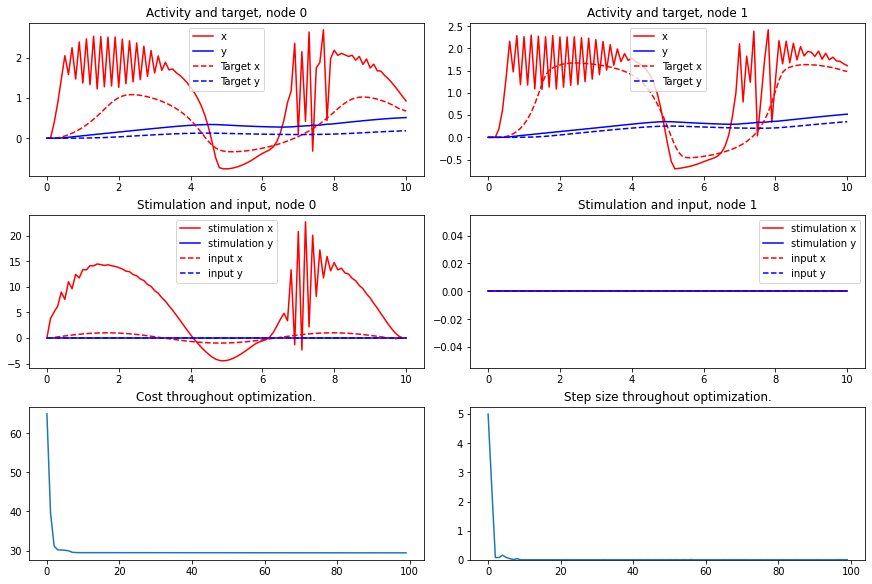

In [25]:
prec_mat = np.zeros( (fhn.params.N, len(fhn.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500,1000,2000,3000], control_matrix=control_mat, precision_matrix=prec_mat)
fhn_controlled.optimize(100)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_nw(state, target, control, input_nw, fhn_controlled.cost_history, fhn_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 1: 0.0025202939168029338
Cost in iteration 2: 0.0024672272951133667
Cost in iteration 10: 0.0021139858733094197
Cost in iteration 50: 0.001129850279326245
Cost in iteration 100: 0.0007017898977712407


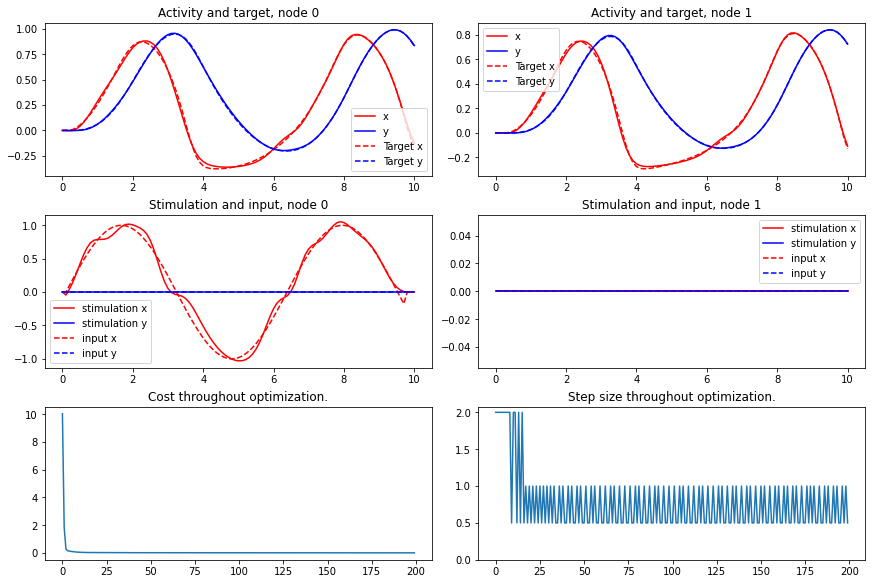

In [20]:
fhn_controlled.optimize(100)
state = fhn_controlled.get_xs()
control = fhn_controlled.control
plot_nw(state, target, control, input_nw, fhn_controlled.cost_history, fhn_controlled.step_sizes_history)